In [266]:
# Complex Semantic Segmentation (U-Net Style)
import os
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import matplotlib.pyplot as plt
from complexPyTorch.complexLayers import ComplexConv2d, ComplexConvTranspose2d, ComplexBatchNorm2d, ComplexAvgPool2d
from complexPyTorch.complexFunctions import complex_relu, complex_dropout


In [267]:
# -----------------------
# CamVid Dataset Loader
# -----------------------
class CamVidDataset(Dataset):
    def __init__(self, image_dir, label_dir, transform=None, target_transform=None):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.transform = transform
        self.target_transform = target_transform

        self.image_names = sorted([
            name for name in os.listdir(image_dir)
            if os.path.exists(os.path.join(label_dir, name.replace(".png", "_L.png")))
        ])

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        img_name = self.image_names[idx]
        img_path = os.path.join(self.image_dir, img_name)
        label_name = img_name.replace(".png", "_L.png")
        label_path = os.path.join(self.label_dir, label_name)

        image = Image.open(img_path).convert('RGB')
        label = Image.open(label_path)

        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)

        return image, label

In [268]:
CAMVID_COLORMAP = {
    (64, 128, 64): 0,      # Animal
    (192, 0, 128): 1,      # Archway
    (0, 128, 192): 2,      # Bicyclist
    (0, 128, 64): 3,       # Bridge
    (128, 0, 0): 4,        # Building
    (64, 0, 128): 5,       # Car
    (64, 0, 192): 6,       # CartLuggagePram
    (192, 128, 64): 7,     # Child
    (192, 192, 128): 8,    # ColumnPole
    (64, 64, 128): 9,      # Fence
    (128, 0, 192): 10,     # LaneMkgsDriv
    (128, 128, 192): 11,   # LaneMkgsNonDriv
    (0, 0, 0): 12,         # Misc_Text
    (64, 64, 0): 13,       # MotorcycleScooter
    (192, 128, 128): 14,   # OtherMoving
    (128, 128, 64): 15,    # ParkingBlock
    (64, 64, 64): 16,      # Pedestrian
    (128, 64, 128): 17,    # Road
    (0, 0, 192): 18,       # RoadShoulder
    (128, 128, 0): 19,     # Sidewalk
    (192, 128, 0): 20,     # SignSymbol
    (128, 128, 128): 21,   # Sky
    (64, 128, 192): 22,    # SUVPickupTruck
    (0, 0, 64): 23,        # TrafficCone
    (0, 64, 64): 24,       # TrafficLight
    (128, 0, 64): 25,      # Train
    (128, 128, 32): 26,    # Tree
    (192, 0, 64): 27,      # Truck_Bus
    (64, 128, 128): 28,    # Tunnel
    (0, 128, 128): 29,     # VegetationMisc
    (0, 0, 0): 30,         # Void (redundant/mask overlap)
    (192, 192, 0): 31      # Wall
}

def rgb_to_class(label_img):
    label = np.array(label_img)
    h, w, _ = label.shape
    mask = np.zeros((h, w), dtype=np.int64)

    for rgb, idx in CAMVID_COLORMAP.items():
        mask[(label == rgb).all(axis=2)] = idx

    return torch.from_numpy(mask)

In [269]:
# -----------------------
# Transforms
# -----------------------
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    lambda x: x.to(torch.complex64)
])

target_transform = transforms.Compose([
    transforms.Resize((128, 128), interpolation=transforms.InterpolationMode.NEAREST),
    lambda img: rgb_to_class(img)
])

In [270]:
# -----------------------
# Dataset and Loader
# -----------------------
camvid_root = "./CamVid"

test_dataset = CamVidDataset(
    image_dir=os.path.join(camvid_root, "test"),
    label_dir=os.path.join(camvid_root, "test_labels"),
    transform=transform,
    target_transform=target_transform
)

train_dataset = CamVidDataset(
    image_dir=os.path.join(camvid_root, "train"),
    label_dir=os.path.join(camvid_root, "train_labels"),
    transform=transform,
    target_transform=target_transform
)

val_dataset = CamVidDataset(
    image_dir=os.path.join(camvid_root, "val"),
    label_dir=os.path.join(camvid_root, "val_labels"),
    transform=transform,
    target_transform=target_transform
)


train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False)

print(f"Train: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)}")

Train: 2103, Val: 100, Test: 232


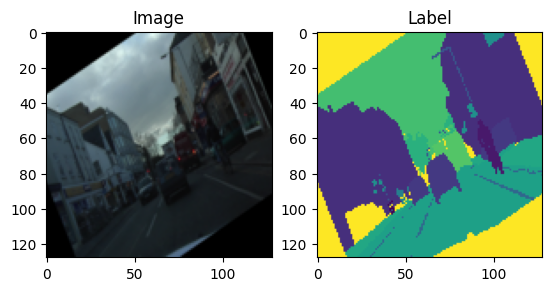

In [271]:
# visualise random dataset
import random
import matplotlib.pyplot as plt
def show_random_image_and_label(loader):
    idx = random.randint(0, len(loader.dataset) - 1)
    image, label = loader.dataset[idx]

    plt.subplot(1, 2, 1)
    plt.imshow(image.permute(1, 2, 0).real)
    plt.title("Image")

    plt.subplot(1, 2, 2)
    plt.imshow(label)
    plt.title("Label")

    plt.show()

show_random_image_and_label(train_loader)

In [272]:
class ComplexAFFBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.global_attn = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(channels, channels, 1),
            nn.Sigmoid()
        )

    def forward(self, feat1, feat2):
        # Fuse features (real + real, imag + imag)
        fused_r = feat1.real + feat2.real
        fused_i = feat1.imag + feat2.imag

        # Shared attention mask
        attn = self.global_attn(torch.sqrt(fused_r**2 + fused_i**2))  # Magnitude-based attention

        out_r = fused_r * attn
        out_i = fused_i * attn
        return torch.complex(out_r, out_i)


In [273]:
def complex_avg_pool2d(x, kernel_size, stride=None, padding=0):
    return torch.complex(
        F.avg_pool2d(x.real, kernel_size, stride, padding),
        F.avg_pool2d(x.imag, kernel_size, stride, padding)
    )

class ComplexReLU(nn.Module):
    def forward(self, x):
        return complex_relu(x)
    
class ComplexDropout(nn.Module):
    def __init__(self, p=0.5):
        super().__init__()
        self.p = p

    def forward(self, inp):
        if not self.training or self.p == 0.0:
            return inp
        mask = torch.ones_like(inp.real)
        mask = F.dropout(mask, self.p, self.training) * 1 / (1 - self.p)
        return torch.complex(inp.real * mask, inp.imag * mask)


In [274]:
# -----------------------
# Complex U-Net
# -----------------------
class ComplexUNet(nn.Module):
    def __init__(self, num_classes, in_channels=3, features=[16, 32, 64, 128]):
        super().__init__()

        self.encoder = nn.ModuleList()
        self.pool = nn.ModuleList()
        self.decoder = nn.ModuleList()
        self.upconv = nn.ModuleList()
        self.aff_blocks = nn.ModuleList()

        # Encoder
        for i in range(len(features)):
            in_ch = in_channels if i == 0 else features[i - 1]
            self.encoder.append(nn.Sequential(
                ComplexConv2d(in_ch, features[i], 3, padding=1),
                ComplexBatchNorm2d(features[i]),
                ComplexReLU(),
                ComplexConv2d(features[i], features[i], 3, padding=1),
                ComplexBatchNorm2d(features[i]),
                ComplexReLU()
            ))
            if i < len(features) - 1:
                self.pool.append(ComplexAvgPool2d(kernel_size=2))

        # Bottleneck with dilation
        self.bottleneck = nn.Sequential(
            ComplexConv2d(features[-1], features[-1], 3, padding=2, dilation=2),
            ComplexBatchNorm2d(features[-1]),
            ComplexReLU(),
            ComplexConv2d(features[-1], features[-1], 3, padding=4, dilation=4),
            ComplexBatchNorm2d(features[-1]),
            ComplexReLU()
        )

        # Decoder
        for i in range(len(features) - 1, 0, -1):
            self.upconv.append(ComplexConvTranspose2d(features[i], features[i-1], 2, stride=2))
            self.aff_blocks.append(ComplexAFFBlock( features[i-1]))
            self.decoder.append(nn.Sequential(
                ComplexConv2d(features[i-1], features[i-1], 3, padding=1),
                ComplexBatchNorm2d(features[i-1]),
                ComplexReLU(),
                ComplexConv2d(features[i-1], features[i-1], 3, padding=1),
                ComplexBatchNorm2d(features[i-1]),
                ComplexReLU()
            ))

        self.final = ComplexConv2d(features[0], num_classes, 1)
        self.dropout = ComplexDropout(0.3)
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, ComplexConv2d):
            nn.init.kaiming_normal_(m.conv_r.weight, mode='fan_out', nonlinearity='relu')
            nn.init.kaiming_normal_(m.conv_i.weight, mode='fan_out', nonlinearity='relu')
            if m.conv_r.bias is not None:
                nn.init.constant_(m.conv_r.bias, 0)
                nn.init.constant_(m.conv_i.bias, 0)

    def forward(self, x):
        skip_connections = []
        for i, enc in enumerate(self.encoder):
            x = enc(x)
            if i < len(self.pool):
                skip_connections.append(x)
                x = self.pool[i](x)

        x = self.bottleneck(x)
        x = self.dropout(x)

        for i in range(len(self.decoder)):
            x = self.upconv[i](x)
            skip = skip_connections[-(i+1)]
            if x.shape[2:] != skip.shape[2:]:
                x = F.interpolate(x, size=skip.shape[2:], mode='bilinear', align_corners=True)
            x = self.aff_blocks[i](x, skip)
            x = self.decoder[i](x)

        x = self.final(x)
        return F.log_softmax(x.abs(), dim=1)


In [275]:

from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import numpy as np
from tqdm import tqdm
# -----------------------
# Evaluation Function (from your previous code, unchanged)
# -----------------------
def evaluate(model, loader, device, num_classes):
    model.eval()
    total_correct = 0
    total_pixels = 0
    iou_per_class = np.zeros(num_classes)
    precision_list, recall_list, f1_list = [], [], []

    conf_matrix = np.zeros((num_classes, num_classes), dtype=np.int64)

    with torch.no_grad():
        for data, target in tqdm(loader, desc="Evaluating"):
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1)

            total_correct += (pred == target).sum().item()
            total_pixels += torch.numel(pred)

            # Flatten for metrics
            pred_flat = pred.view(-1).cpu().numpy()
            target_flat = target.view(-1).cpu().numpy()

            conf_matrix += confusion_matrix(target_flat, pred_flat, labels=np.arange(num_classes))

            # Metrics per batch
            precision_list.append(precision_score(target_flat, pred_flat, average='macro', zero_division=0))
            recall_list.append(recall_score(target_flat, pred_flat, average='macro', zero_division=0))
            f1_list.append(f1_score(target_flat, pred_flat, average='macro', zero_division=0))

    # Pixel accuracy
    pixel_acc = total_correct / total_pixels

    # IoU per class
    for i in range(num_classes):
        tp = conf_matrix[i, i]
        fp = conf_matrix[:, i].sum() - tp
        fn = conf_matrix[i, :].sum() - tp
        denom = tp + fp + fn
        iou_per_class[i] = tp / denom if denom != 0 else 0

    mean_iou = np.mean(iou_per_class)
    precision = np.mean(precision_list)
    recall = np.mean(recall_list)
    f1 = np.mean(f1_list)

    print(f"Pixel Accuracy: {pixel_acc:.4f}")
    print(f"Mean IoU:       {mean_iou:.4f}")
    print(f"Precision:      {precision:.4f}")
    print(f"Recall:         {recall:.4f}")
    print(f"F1 Score:       {f1:.4f}")
    return {
        'pixel_accuracy': pixel_acc,
        'mean_iou': mean_iou,
        'precision': precision,
        'recall': recall,
        'f1_score': f1
    }

In [276]:
# -----------------------
# Train and Evaluate
# -----------------------
def train(model, loader, optimizer, device):
    model.train()
    total_loss = 0
    for data, target in loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        # loss = F.nll_loss(output, target) # Another loss function
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Train Loss: {total_loss / len(loader):.4f}")

In [277]:
def validate(model, loader, device):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            # loss = F.nll_loss(output, target) # Another loss function
            loss = F.cross_entropy(output, target)
            total_loss += loss.item()
    return total_loss / len(loader)

In [278]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
# model.load_state_dict(torch.load('best_model.pth', map_location=device))
# model.to(device)
model.eval()

ComplexUNet(
  (encoder): ModuleList(
    (0): Sequential(
      (0): ComplexConv2d(
        (conv_r): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv_i): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (1): ComplexBatchNorm2d()
      (2): ComplexReLU()
      (3): ComplexConv2d(
        (conv_r): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv_i): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (4): ComplexBatchNorm2d()
      (5): ComplexReLU()
    )
    (1): Sequential(
      (0): ComplexConv2d(
        (conv_r): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv_i): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (1): ComplexBatchNorm2d()
      (2): ComplexReLU()
      (3): ComplexConv2d(
        (conv_r): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv_i): Conv2d(32, 

In [289]:
# -----------------------
# Setup and Run
# -----------------------

model = ComplexUNet(num_classes=32).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


num_epochs = 50
for epoch in range(num_epochs):
    print(f"\nEpoch {epoch + 1}")
    
    train(model, train_loader, optimizer, device)
    val_loss = validate(model, val_loader, device)
    print(f"Validation Loss: {val_loss:.4f}")
   
    torch.save(model.state_dict(), "best_model.pth")
    print("Saved new best model.")
   



Epoch 20
Train Loss: 0.2776
Validation Loss: 0.2963
Saved new best model.

Epoch 21
Train Loss: 0.2688
Validation Loss: 0.5317
Saved new best model.

Epoch 22
Train Loss: 0.2620
Validation Loss: 0.3255
Saved new best model.

Epoch 23
Train Loss: 0.2566
Validation Loss: 0.3409
Saved new best model.

Epoch 24
Train Loss: 0.2507
Validation Loss: 0.2998
Saved new best model.

Epoch 25
Train Loss: 0.2469
Validation Loss: 0.3130
Saved new best model.

Epoch 26
Train Loss: 0.2381
Validation Loss: 0.2947
Saved new best model.

Epoch 27
Train Loss: 0.2366
Validation Loss: 0.2830
Saved new best model.

Epoch 28
Train Loss: 0.2316
Validation Loss: 0.2720
Saved new best model.

Epoch 29
Train Loss: 0.2282
Validation Loss: 0.2810
Saved new best model.

Epoch 30
Train Loss: 0.2259
Validation Loss: 0.2946
Saved new best model.

Epoch 31
Train Loss: 0.2208
Validation Loss: 0.2603
Saved new best model.

Epoch 32
Train Loss: 0.2215
Validation Loss: 0.2642
Saved new best model.

Epoch 33
Train Loss: 0.2

In [290]:
# Save model weights
torch.save(model.state_dict(), 'complex_unet_final.pth')

# # Load the saved model weights



In [307]:
import matplotlib.pyplot as plt

def test(model, loader, device, num_images=5):
    model.eval()
    shown = 0

    with torch.no_grad():
        for data, target in loader:
            data = data.to(device)
            output = model(data)
            pred = output.argmax(dim=1).cpu()  # Shape: [batch_size, H, W]

            for i in range(data.size(0)):
                img = data[i].cpu()
                mask = pred[i]

                plt.figure(figsize=(9, 3))
                plt.subplot(1, 2, 1)
                plt.title("Input Image")
                plt.imshow(img.abs().permute(1, 2, 0))  # Handle complex input
                plt.axis("off")

                plt.subplot(1, 2, 2)
                plt.title("Predicted Segmentation")
                plt.imshow(mask, cmap='tab20')
                plt.axis("off")

                plt.show()

                shown += 1
                if shown >= num_images:
                    return  # Stop after showing num_images


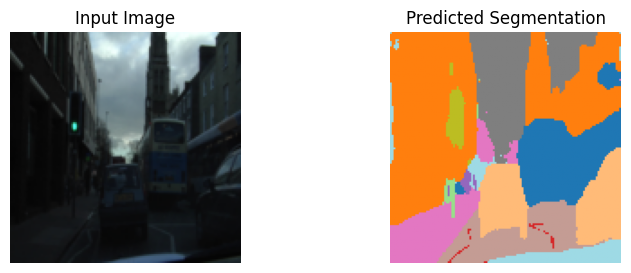

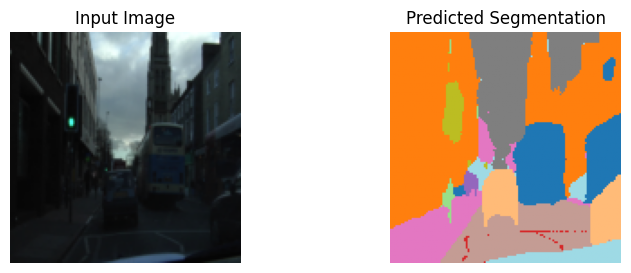

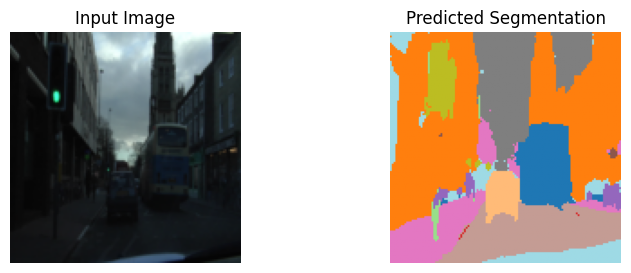

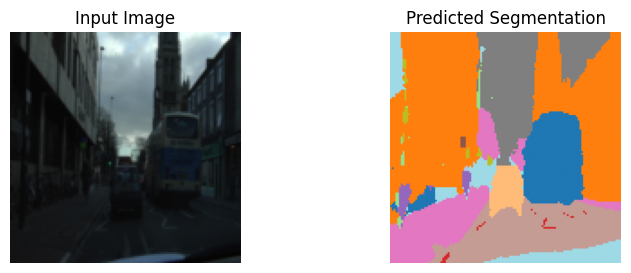

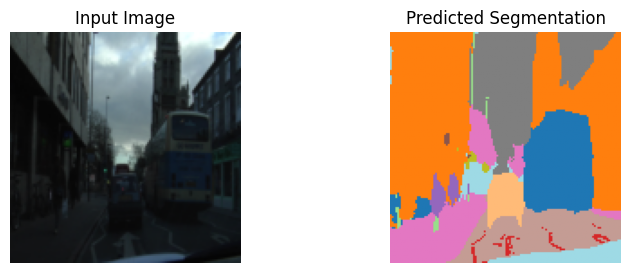

In [308]:
test(model, test_loader, device, num_images=5)


In [292]:
from sklearn.metrics import (
    confusion_matrix,
    precision_score,
    recall_score,
    f1_score
)
import numpy as np
from tqdm import tqdm
import torch

def evaluate(model, loader, device, num_classes=32):
    model.eval()
    total_correct = 0
    total_pixels = 0
    iou_per_class = np.zeros(num_classes)
    conf_matrix = np.zeros((num_classes, num_classes), dtype=np.int64)

    # Collect flattened predictions & labels for F1
    all_preds, all_targets = [], []

    with torch.no_grad():
        for data, target in tqdm(loader, desc="Evaluating"):
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1)

            # Pixel‑accuracy
            total_correct += (pred == target).sum().item()
            total_pixels += pred.numel()

            # Flatten for global F1
            p = pred.view(-1).cpu().numpy()
            t = target.view(-1).cpu().numpy()
            all_preds.append(p)
            all_targets.append(t)

            # Build confusion matrix for IoU
            conf_matrix += confusion_matrix(t, p, labels=np.arange(num_classes))

    # Concatenate full arrays
    all_preds = np.concatenate(all_preds)
    all_targets = np.concatenate(all_targets)

    # Macro Precision & Recall
    macro_prec = precision_score(all_targets, all_preds, average='macro', zero_division=0)
    macro_rec  = recall_score   (all_targets, all_preds, average='macro', zero_division=0)

    # Macro & Micro F1
    macro_f1 = f1_score(all_targets, all_preds, average='macro', zero_division=0)
    micro_f1 = f1_score(all_targets, all_preds, average='micro', zero_division=0)

    # Pixel accuracy & Mean IoU
    pixel_acc = total_correct / total_pixels
    for i in range(num_classes):
        tp = conf_matrix[i, i]
        fp = conf_matrix[:, i].sum() - tp
        fn = conf_matrix[i, :].sum() - tp
        denom = tp + fp + fn
        iou_per_class[i] = tp / denom if denom else 0
    mean_iou = iou_per_class.mean()

    # Print results
    print(f"Pixel Accuracy:    {pixel_acc:.4f}")
    print(f"Mean IoU:          {mean_iou:.4f}")
    print(f"Macro Precision:   {macro_prec:.4f}")
    print(f"Macro Recall:      {macro_rec:.4f}")
    print(f"Macro F1 Score:    {macro_f1:.4f}")
    print(f"Micro F1 Score:    {micro_f1:.4f}")

    return {
        'pixel_accuracy': pixel_acc,
        'mean_iou': mean_iou,
        'macro_precision': macro_prec,
        'macro_recall': macro_rec,
        'macro_f1': macro_f1,
        'micro_f1': micro_f1
    }


In [296]:
results = evaluate(model, test_loader, device, num_classes=32)

Evaluating: 100%|██████████| 116/116 [00:10<00:00, 11.60it/s]


Pixel Accuracy:    0.9169
Mean IoU:          0.4479
Macro Precision:   0.7313
Macro Recall:      0.6651
Macro F1 Score:    0.6814
Micro F1 Score:    0.9169


In [294]:
results = evaluate(model, train_loader, device, num_classes=32)

Evaluating: 100%|██████████| 1052/1052 [01:19<00:00, 13.30it/s]


Pixel Accuracy:    0.9320
Mean IoU:          0.4945
Macro Precision:   0.8006
Macro Recall:      0.7138
Macro F1 Score:    0.7365
Micro F1 Score:    0.9320


In [295]:
results = evaluate(model, val_loader, device, num_classes=32)

Evaluating: 100%|██████████| 50/50 [00:04<00:00, 11.18it/s]


Pixel Accuracy:    0.9187
Mean IoU:          0.4567
Macro Precision:   0.7367
Macro Recall:      0.6928
Macro F1 Score:    0.7007
Micro F1 Score:    0.9187
